In [14]:
import torch
from torch import nn 
from torch import optim
import math
import numpy as np
from matplotlib import pyplot as plt

In [15]:
class NN(nn.Module):
    def __init__(self,):
        super(NN, self).__init__()
        #Linear layers
        self.mod = nn.Sequential(
            nn.Linear(1, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 20),
            torch.nn.Tanh(),
            nn.Linear(20, 1)
        )
        
    def forward(self, inpu):
        out = self.mod(inpu)
        return out

In [16]:
net = NN()
print(net)

params = list(net.parameters())
#print(len(params))
for par in params:
    print(par.shape)

NN(
  (mod): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): Tanh()
    (16): Linear(in_features=20, out_features=1, bias=True)
  )
)
torch.Size([20, 1])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size

In [20]:
class Model:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.model = NN().to(device)
        
        #Max iteration
        self.max_iter = 1000
        
        #Criterion for loss 
        self.criterion = nn.MSELoss()
        
        #Optimizer
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=100,
            tolerance_grad=1e-6, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe" 
        )
        
        #Initialization for training
        self.t_step = 0.01
        t = torch.arange(0, 15 + self.t_step, self.t_step) #create grid for t-axis #[0, 15] 1500
        #print(t.shape)
        #Create grid for solution
        self.grid = t.reshape(1, -1).T.to(device)  # no need to create grid for 1D problem #collocations
        self.grid.requires_grad = True
        #print(self.grid.shape)
        #Training data
        initial = torch.tensor([t[0]]) # Points for boundary conditions (both are same) #t=0, t=0, t=0, t=0, ...
        #print(initial.shape)
        self.train_points = initial.reshape(1, -1).T.to(device) # Training points as a grid
        self.train_points.requires_grad = True
        #print(self.train_points.shape)
        self.u_initial = torch.ones(len(initial)).reshape(1,-1).T.to(device) #1, 1, 1, 1
        self.ut_initial = -1*torch.ones(len(initial)).reshape(1,-1).T.to(device) #-1, -1, -1, -1, -1 ...
        #print(self.u_initial.shape)
        #print(self.ut_initial.shape)
        #print(self.u_initial)
        #print(self.ut_initial)
        #print(self.train_points)

        self.iter = 1


    
    def loss(self):
        self.optimizer.zero_grad()
        
        y = self.model(self.train_points) #0 taille 1500
        dy_dt = torch.autograd.grad(inputs=self.train_points, outputs=y, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)[0]
        
        loss = self.criterion(y, self.u_initial) #Compute first part of loss #should be a constant
        loss += self.criterion(dy_dt, self.ut_initial) #Compute second part of loss #should be a constant
        
        u = self.model(self.grid)
        #Compute gradients of grid with respect to t
        du_dt = torch.autograd.grad(inputs=self.grid, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dt2 = torch.autograd.grad(inputs=self.grid, outputs=du_dt, grad_outputs=torch.ones_like(du_dt), retain_graph=True, create_graph=True)[0]

        loss += self.criterion(du_dt2 + 2*du_dt + u, torch.exp(-self.grid)*torch.cos(2*self.grid)) #third part of loss, using f(t,x) as in paper
        
        loss.backward()
        #Print loss every 100 iteration
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss

    def train(self):
        for i in range(self.max_iter):
            self.optimizer.step(self.loss)
        #self.lbfgs.step(self.loss)
    
    def predict(self):
        y_pred = self.model(self.grid)
        dy_dt = torch.autograd.grad(inputs=self.grid, outputs=y_pred, grad_outputs=torch.ones_like(y_pred), retain_graph=True, create_graph=True)[0]
        dy_dt2 = torch.autograd.grad(inputs=self.grid, outputs=dy_dt, grad_outputs=torch.ones_like(dy_dt), retain_graph=True, create_graph=True)[0]
        return dy_dt2 + 2*dy_dt + y_pred - torch.exp(-self.grid)*torch.cos(2*self.grid)

In [21]:
model = Model()
model.train()

100 9.806160960579291e-05
200 3.0458155379164964e-05
300 2.1461642973008566e-05
400 1.6279282135656103e-05
500 1.0916713108599652e-05
600 6.783859589631902e-06
700 3.5588432183430996e-06
800 2.193517047999194e-06
900 1.8465620996721555e-06
1000 1.5318776149797486e-06
1100 1.2590396636369405e-06
1200 1.0448112561789458e-06
1300 9.383588803757448e-07
1400 8.114756155919167e-07
1500 5.895538492950436e-07
1600 5.729116310249083e-07
1700 5.725143523704901e-07
1800 5.725181608795538e-07
1900 5.725096343667246e-07
2000 5.725464120587276e-07
2100 5.725149208046787e-07
2200 5.725207188334025e-07
2300 5.725096343667246e-07
2400 5.725143523704901e-07
2500 5.725181608795538e-07
2600 5.725096343667246e-07
2700 5.725464120587276e-07
2800 5.725149208046787e-07
2900 5.725207188334025e-07
3000 5.725096343667246e-07
3100 5.725143523704901e-07
3200 5.725181608795538e-07
3300 5.725096343667246e-07
3400 5.725464120587276e-07
3500 5.725149208046787e-07
3600 5.725207188334025e-07
3700 5.725096343667246e-07
3

tensor(4.5287e-08)


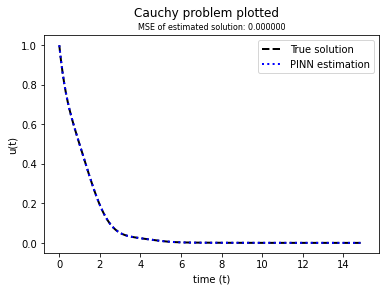

In [22]:
def result_funct(t):
    return (5/4)*torch.exp(-t) - (1/4)*torch.exp(-t)*torch.cos(2*t)

time_step = 0.01 #pourquoi /10 #0.001
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
time = torch.arange(0, 15 + time_step, time_step).reshape(1,-1).T.to(device)

f_pred = model.predict()
mod = model.model
mod.eval()
with torch.no_grad():
    y_pred = mod(time)#.cpu()
    #f_pred = 

y_pred = y_pred.detach().cpu()
time = time.detach().cpu()
mse = nn.MSELoss()
error = mse(y_pred, result_funct(time))

fig, ax = plt.subplots()
ax.plot(time, result_funct(time), color='black',linestyle='--', linewidth=2, label='True solution')
ax.plot(time, y_pred, color='blue', linestyle=':', linewidth=2, label='PINN estimation')
ax.legend()
plt.suptitle("Cauchy problem plotted")
plt.title("MSE of estimated solution: %f" %error, fontsize=8)
plt.xlabel("time (t)")
plt.ylabel("u(t)")
fig.show
print(error)

In [23]:
np.linalg.norm(y_pred - result_funct(torch.arange(0, 15 + 0.01, 0.01).reshape(1,-1).T),2)/np.linalg.norm(result_funct(torch.arange(0, 15 + 0.01, 0.01).reshape(1,-1).T),2) 

0.001023609

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

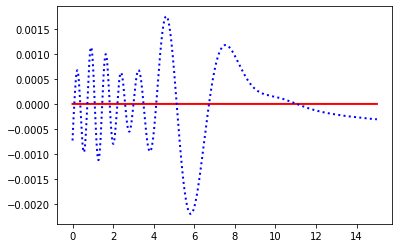

In [24]:
fig, ax = plt.subplots()

ax.plot(torch.arange(0, 15 + 0.01, 0.01).reshape(1,-1).T, np.zeros(len(torch.arange(0, 15 + 0.01, 0.01).reshape(1,-1).T)), color='red', linewidth=2, label='DE true')
ax.plot(torch.arange(0, 15 + 0.01, 0.01).reshape(1,-1).T, f_pred.detach().cpu(), color='blue', linestyle=':', linewidth=2, label='DE')
fig.show 

In [25]:
torch.mean((f_pred-torch.mean(f_pred,axis=0))**2,axis=0)[0]

tensor(5.7249e-07, device='cuda:0', grad_fn=<SelectBackward0>)